In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install tensorflow
!pip install transformers


In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from PIL import Image
import numpy as np
import sys
import os
import csv

# Function to create a list of files, labels, and names
def createFileList(myDir, format='.jpg'):
    fileList = []
    labels = []
    names = []
    for root, dirs, files in os.walk(myDir, topdown=True):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
                # Infer the class based on the file name
                if name.lower().startswith('healthy'):
                    labels.append('0')
                elif name.lower().startswith('unhealthy'):
                    labels.append('1')
                else:
                    labels.append('-1')  # A placeholder value for files with unknown class
                names.append(name)
    return fileList, labels, names

# Function to reduce the dimensions of the image
def reduce_dimensions(image_path, new_width=100, new_height=100):
    img = Image.open(image_path)
    img = img.resize((new_width, new_height))
    return img

# Directory where the images are located
image_dir = 'D:\sem7\project\projec\inalproj.csv'



# Create a list of files, labels, and names
myFileList, labels, names = createFileList(image_dir, '.jpg')

# Loop through each file in the list
i = 0
for file in myFileList:
    print(file)

    # Reduce the dimensions of the image while keeping 3 color channels
    reduced_img = reduce_dimensions(file, new_width=100, new_height=100)

    # Continue with the rest of your code...
    width, height = reduced_img.size
    format = reduced_img.format
    mode = reduced_img.mode

    # Convert to numpy array while keeping 3 channels
    value = np.array(reduced_img).reshape((width, height, 3))

    # Flatten the array and append the label
    value = value.flatten()
    value = np.append(value, labels[i])
    i += 1

    print(value)
    with open("finalproj.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)


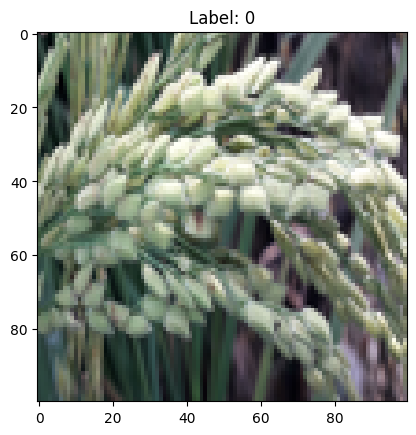

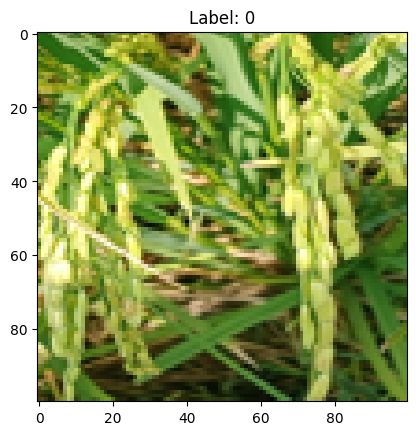

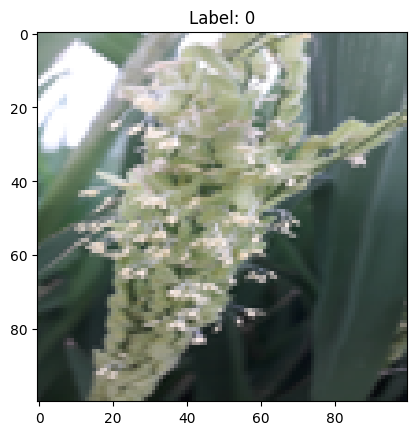

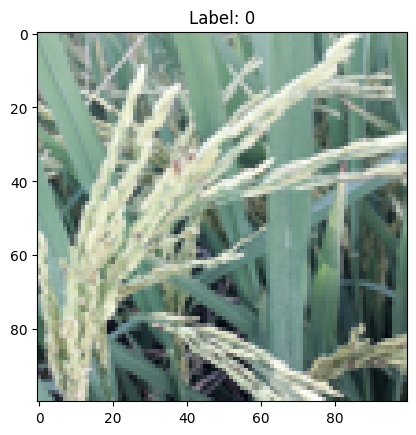

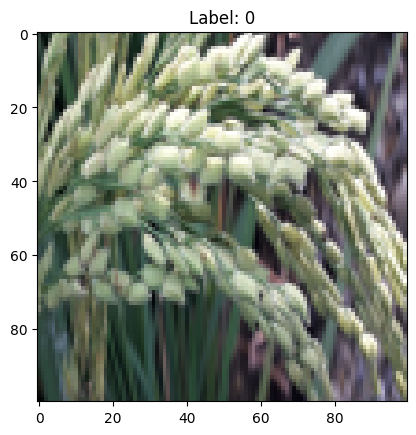

In [4]:
import numpy as np
import csv
from PIL import Image
import matplotlib.pyplot as plt

# Load data from the CSV file
csv_file = 'Finalproj.csv'
data = np.loadtxt(csv_file, delimiter=',')

# Extract image data and labels
images = data[:, :-1]
labels = data[:, -1]

# Choose how many images you want to display
num_images_to_display = 5

# Loop through and display some images
for i in range(num_images_to_display):
    # Reshape the flattened image data to its original shape
    image_shape = (100, 100 , 3)  # Change this based on your image dimensions
    img_data = images[i, :].reshape(image_shape)

    # Convert to PIL image for display
    img = Image.fromarray(img_data.astype(np.uint8))

    # Display the image with its label
    plt.imshow(img, cmap='gray')  # Assuming images are grayscale
    plt.title(f"Label: {int(labels[i])}")
    plt.show()


In [5]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split

# Load data from the CSV file
csv_file = 'Finalproj.csv'

data = np.loadtxt(csv_file, delimiter=',')

# Extract features (X) and labels (y)
X = data[:, :-1]
y = data[:, -1]

image_shape = (100, 100, 3)
X = X.reshape(-1, *image_shape).astype(np.uint8)

# Reshape y to a column vector if it's a 1D array
y = y.reshape(-1, 1)

# Split the data into training and testing sets
test_size = 0.3  # You can adjust the test size as needed
random_state = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (679, 100, 100, 3)
y_train shape: (679, 1)
X_test shape: (291, 100, 100, 3)
y_test shape: (291, 1)


In [6]:
class_names= ["healthy" ,"Unhealthy"]

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (100,100,3)

In [9]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize

def regnet_bottleneck(x, channels_in, channels_out, stride):
    shortcut = x

    # The first 1x1 convolution
    x = layers.Conv2D(channels_out // 4, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # The 3x3 convolution with the specified stride
    x = layers.Conv2D(channels_out // 4, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # The second 1x1 convolution
    x = layers.Conv2D(channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # If the number of channels changes, apply a 1x1 convolution to the shortcut
    if channels_in != channels_out or stride != (1, 1):
        shortcut = layers.Conv2D(channels_out, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_regnet(input_shape=(100, 100, 3), num_classes=1):
    # Initial stem
    input_tensor = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Stage 1
    x = regnet_bottleneck(x, 32, 64, (1, 1))
    x = regnet_bottleneck(x, 64, 64, (1, 1))

    # Stage 2
    x = regnet_bottleneck(x, 64, 128, (2, 2))
    x = regnet_bottleneck(x, 128, 128, (1, 1))

    # Stage 3
    x = regnet_bottleneck(x, 128, 256, (2, 2))
    x = regnet_bottleneck(x, 256, 256, (1, 1))

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

# Create the RegNet model
model = build_regnet()

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = optimizers.Adam(lr=0.001)


# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)






# Create the RegNet model
model = build_regnet()
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 50, 50, 32)           896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 50, 50, 32)           128       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 50, 50, 32)           0         ['batch_normalization_22

In [10]:
nb_layers = len(model.layers)
print("Numbers of Layers =" , nb_layers)
print(model.layers[nb_layers - 2].name)  # pre- Last name
print(model.layers[nb_layers - 1].name)

Numbers of Layers = 72
global_average_pooling2d_1
dense_1


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train, verbose=2, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10



22/22 - 13s - loss: 0.6236 - accuracy: 0.6230 - val_loss: 0.9855 - val_accuracy: 0.4364 - 13s/epoch - 579ms/step
Epoch 2/10
22/22 - 6s - loss: 0.5007 - accuracy: 0.7437 - val_loss: 1.6512 - val_accuracy: 0.4364 - 6s/epoch - 278ms/step
Epoch 3/10
22/22 - 6s - loss: 0.4084 - accuracy: 0.8130 - val_loss: 1.5231 - val_accuracy: 0.4364 - 6s/epoch - 268ms/step
Epoch 4/10
22/22 - 6s - loss: 0.3048 - accuracy: 0.8837 - val_loss: 2.1501 - val_accuracy: 0.4364 - 6s/epoch - 278ms/step
Epoch 5/10
22/22 - 6s - loss: 0.2497 - accuracy: 0.9116 - val_loss: 1.5466 - val_accuracy: 0.4364 - 6s/epoch - 276ms/step
Epoch 6/10
22/22 - 6s - loss: 0.2275 - accuracy: 0.9175 - val_loss: 3.1945 - val_accuracy: 0.4364 - 6s/epoch - 255ms/step
Epoch 7/10
22/22 - 6s - loss: 0.1421 - accuracy: 0.9558 - val_loss: 3.1979 - val_accuracy: 0.4364 - 6s/epoch - 257ms/step
Epoch 8/10
22/22 - 5s - loss: 0.1878 - accuracy: 0.9146 - val_loss: 3.1666 - val_accuracy: 0.4433 - 5s/epoch - 241ms/step
Epoch 9/10
22/22 - 6s - loss: 0.1

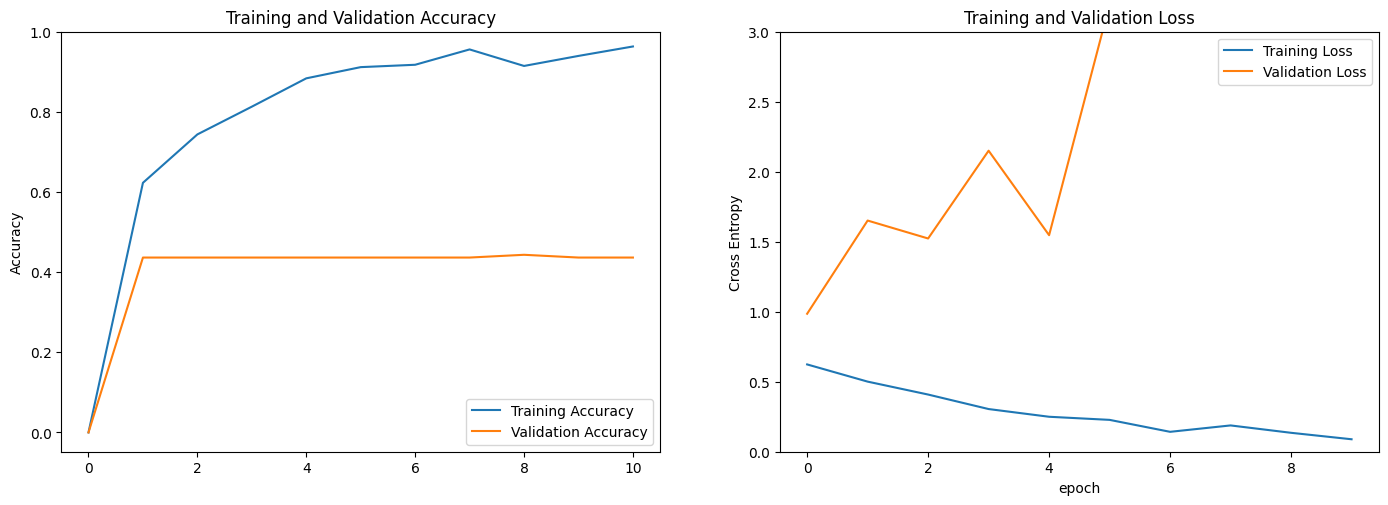

In [13]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

true_labels = y_test
predictions = model.predict(X_test)
predicted_labels = np.round(predictions)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

10/10 [==============================] - 1s 81ms/step
Precision: 1.0
Recall: 0.024390243902439025
F1-score: 0.047619047619047616

Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      1.00      0.61       127
         1.0       1.00      0.02      0.05       164

    accuracy                           0.45       291
   macro avg       0.72      0.51      0.33       291
weighted avg       0.76      0.45      0.29       291



In [15]:
# Evaluate the model on the test set
test_score = model.evaluate(X_test, y_test, verbose=2)

# The test_score will contain the loss value and metrics values
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])



10/10 - 1s - loss: 2.6827 - accuracy: 0.4502 - 746ms/epoch - 75ms/step
10/10 [==============================] - 1s 72ms/step - loss: 2.6827 - accuracy: 0.4502
Test Accuracy: 0.4501718282699585
Test Loss: 2.6826558113098145
Test Accuracy: 0.4501718282699585


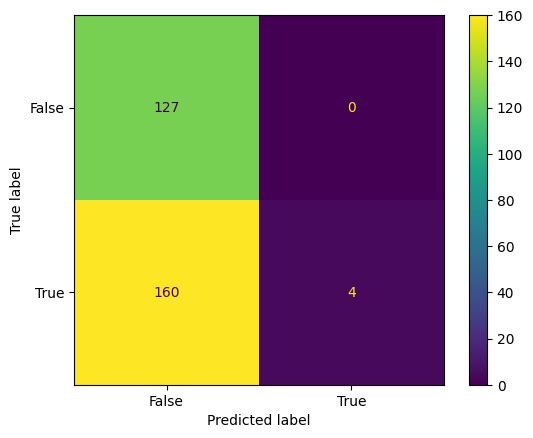

In [16]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [17]:
!pip install scikit-optimize
!pip install --upgrade tensorflow scikit-learn





     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ?

ERROR: Exception:
Traceback (most recent call last):
  File "D:\sem 5\New folder\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "D:\sem 5\New folder\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "D:\sem 5\New folder\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "D:\sem 5\New folder\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "D:\sem 5\New folder\lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
  File "D:\sem 5\New folder\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "D:\sem 5\New folder\lib\ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "D:\sem 5\New folder\lib\ssl.py", line 1130, in read
    

   ---------------------------------------- 1.2/376.9 MB 79.4 kB/s eta 1:18:51
   ---------------------------------------- 1.2/376.9 MB 79.4 kB/s eta 1:18:51
   ---------------------------------------- 1.2/376.9 MB 79.6 kB/s eta 1:18:39
   ---------------------------------------- 1.2/376.9 MB 80.3 kB/s eta 1:17:58
   ---------------------------------------- 1.2/376.9 MB 80.7 kB/s eta 1:17:37
   ---------------------------------------- 1.2/376.9 MB 80.7 kB/s eta 1:17:37
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.9 MB 81.7 kB/s eta 1:16:41
   ---------------------------------------- 1.2/376.

In [14]:
import skopt
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping



from keras.callbacks import EarlyStopping
from time import time
from sklearn import datasets
%matplotlib inline

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

def build_regnet():
    model = Sequential()
    # Add your layers here (e.g., Conv2D, MaxPooling2D, etc.)
    return model

def REGNET(optimizer, neurons, batch_size, epochs, activation, patience):
    model = build_regnet()
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid', name="classification"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor="loss", patience=patience)
    history = model.fit(X_train, y_train, epochs=epochs, callbacks=[early_stopping], batch_size=batch_size, verbose=1)
    return model

# Call the function
model = REGNET(optimizer='adam', neurons=512, batch_size=64, epochs=5, activation='leaky_relu', patience=11)



Epoch 1/5
11/11 [==============================] - 1s 5ms/step - loss: 11.9700 - accuracy: 0.5155
Epoch 2/5
11/11 [==============================] - 0s 5ms/step - loss: 4.4730 - accuracy: 0.5228
Epoch 3/5
11/11 [==============================] - 0s 5ms/step - loss: 2.0606 - accuracy: 0.5199
Epoch 4/5
11/11 [==============================] - 0s 5ms/step - loss: 1.1863 - accuracy: 0.5390
Epoch 5/5
11/11 [==============================] - 0s 5ms/step - loss: 1.0201 - accuracy: 0.5552


In [20]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5636


[0.6919695138931274, 0.5635738968849182]

In [34]:
!pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [71]:
from skopt import BayesSearchCV
from time import time
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import xlsxwriter
from xlsxwriter import Workbook

# Assuming you have a function CNN defined for your Keras model

# Define the parameter search space
rf_params = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu', 'tanh','leaky_relu','sigmoid','softmax'],
    'batch_size': (16,32, 64),  # Adjust based on your preference
    'neurons': (16, 32,64,128,256,512),
    'epochs': (10,20,30,50),
    'patience': (3, 20)
}

# Create a KerasClassifier instance
clf = KerasClassifier(build_fn=REGNET, verbose=0)

# Create a BayesSearchCV instance
ga1 = BayesSearchCV(
    estimator=clf,
    search_spaces=rf_params,
    scoring="accuracy",
    cv=5,
    verbose=10,
    n_iter=10,  # Number of evaluations
    n_jobs=10
)

results = []

for i in range(10):  # Iterate over different runs
    start = time()
    ga1.fit(X_train, y_train)
    end = time()

    # Calculate precision, recall, and F1 score
    y_pred = ga1.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    result = {
        'Hyperparameters': ga1.best_params_,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Time taken (s)': end - start,
        'Accuracy':ga1.best_score_
    }
    results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Write results to Excel
with pd.ExcelWriter('regnet1_parameter_search_results1.xlsx') as writer:
    results_df.to_excel(writer, sheet_name='Results1', index=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/tmp/ipykernel_5665/3835882595.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=REGNET, verbose=0)
2024-02-21 14:18:40.154065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:40.155286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:40.163693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:40.211265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:40.217898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[CV 3/5; 1/1] START activation=sigmoid, batch_size=32, epochs=10, neurons=128, optimizer=sgd, patience=7
[CV 5/5; 1/1] START activation=sigmoid, batch_size=32, epochs=10, neurons=128, optimizer=sgd, patience=7
[CV 1/5; 1/1] START activation=sigmoid, batch_size=32, epochs=10, neurons=128, optimizer=sgd, patience=7
[CV 2/5; 1/1] START activation=sigmoid, batch_size=32, epochs=10, neurons=128, optimizer=sgd, patience=7
[CV 4/5; 1/1] START activation=sigmoid, batch_size=32, epochs=10, neurons=128, optimizer=sgd, patience=7
Epoch 1/10


2024-02-21 14:18:40.829344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:40.841583: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:40.844428: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:40.893262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:40.911523: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
22/22 [==============================] - 1s 3ms/step - loss: 0.6879 - accuracy: 0.5582
Epoch 2/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5464
Epoch 3/10
22/22 [==============================] - 1s 4ms/step - loss: 0.6957 - accuracy: 0.5596
Epoch 2/10
22/22 [==============================] - 1s 3ms/step - loss: 0.6808 - accuracy: 0.5803
Epoch 2/10
22/22 [==============================] - 1s 3ms/step - loss: 0.6746 - accuracy: 0.5965
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5390
Epoch 3/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5714
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5862
Epoch 3/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.5611
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6734 - accu

2024-02-21 14:18:44.367617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:44.372373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:44.378156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:44.994339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:44.994339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:18:45.066361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:45.094181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:45.094857: E 

[CV 5/5; 1/1] START activation=relu, batch_size=16, epochs=20, neurons=32, optimizer=adam, patience=9
[CV 3/5; 1/1] START activation=relu, batch_size=16, epochs=20, neurons=32, optimizer=adam, patience=9
[CV 4/5; 1/1] START activation=relu, batch_size=16, epochs=20, neurons=32, optimizer=adam, patience=9
Epoch 1/20
Epoch 1/20
Epoch 1/20
[CV 1/5; 1/1] START activation=relu, batch_size=16, epochs=20, neurons=32, optimizer=adam, patience=9
[CV 2/5; 1/1] START activation=relu, batch_size=16, epochs=20, neurons=32, optimizer=adam, patience=9
37/43 [========================>.....] - ETA: 0s - loss: 1.4633 - accuracy: 0.5355 Epoch 1/20


2024-02-21 14:18:45.760510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:18:45.781555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


43/43 [==============================] - 1s 2ms/step - loss: 1.3612 - accuracy: 0.5479
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5582
Epoch 3/20
43/43 [==============================] - 1s 2ms/step - loss: 1.9940 - accuracy: 0.5272
Epoch 2/20
43/43 [==============================] - 1s 2ms/step - loss: 1.6234 - accuracy: 0.5596
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.7610 - accuracy: 0.5596
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.7712 - accuracy: 0.5626
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.8042 - accuracy: 0.5420
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.7952 - accuracy: 0.5847
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.7873 - accuracy: 0.5596
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.8928 - accuracy: 0.5626
Epoch 4/20
43/43 [=============

2024-02-21 14:23:08.051146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11/11 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5184
Epoch 18/30
11/11 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5847
[CV 5/5; 1/1] START activation=tanh, batch_size=64, epochs=30, neurons=256, optimizer=adam, patience=6


2024-02-21 14:23:09.410602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/30
5/5 [==============================] - 0s 2ms/step
[CV 1/5; 1/1] END activation=tanh, batch_size=64, epochs=30, neurons=256, optimizer=adam, patience=6;, score=0.618 total time=   3.9s
5/5 [==============================] - 0s 1ms/step
[CV 2/5; 1/1] END activation=tanh, batch_size=64, epochs=30, neurons=256, optimizer=adam, patience=6;, score=0.610 total time=   4.0s
5/5 [==============================] - 0s 1ms/step
[CV 3/5; 1/1] END activation=tanh, batch_size=64, epochs=30, neurons=256, optimizer=adam, patience=6;, score=0.596 total time=   4.1s
11/11 [==============================] - 1s 2ms/step - loss: 1.3828 - accuracy: 0.4934
Epoch 2/30
11/11 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5317
Epoch 3/30
11/11 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.6024
Epoch 4/30
11/11 [==============================] - 0s 2ms/step - loss: 0.6777 - accuracy: 0.5523
Epoch 5/30
11/11 [==============================] - 0

2024-02-21 14:23:56.230150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


5/5 [==============================] - 0s 1ms/step
[CV 2/5; 1/1] END activation=softmax, batch_size=32, epochs=10, neurons=32, optimizer=rmsprop, patience=11;, score=0.485 total time=   1.6s
5/5 [==============================] - 0s 1ms/step
[CV 1/5; 1/1] END activation=softmax, batch_size=32, epochs=10, neurons=32, optimizer=rmsprop, patience=11;, score=0.522 total time=   1.7s
5/5 [==============================] - 0s 1ms/step
[CV 4/5; 1/1] END activation=softmax, batch_size=32, epochs=10, neurons=32, optimizer=rmsprop, patience=11;, score=0.485 total time=   1.7s
5/5 [==============================] - 0s 967us/step
[CV 3/5; 1/1] END activation=softmax, batch_size=32, epochs=10, neurons=32, optimizer=rmsprop, patience=11;, score=0.485 total time=   1.7s
[CV 5/5; 1/1] START activation=softmax, batch_size=32, epochs=10, neurons=32, optimizer=rmsprop, patience=11
Epoch 1/10


2024-02-21 14:23:56.969352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


22/22 [==============================] - 0s 1ms/step - loss: 0.7106 - accuracy: 0.5052
Epoch 2/10
22/22 [==============================] - 0s 1ms/step - loss: 0.7072 - accuracy: 0.5052
Epoch 3/10
22/22 [==============================] - 0s 907us/step - loss: 0.7047 - accuracy: 0.5052
Epoch 4/10
22/22 [==============================] - 0s 881us/step - loss: 0.7029 - accuracy: 0.5052
Epoch 5/10
22/22 [==============================] - 0s 807us/step - loss: 0.7013 - accuracy: 0.5052
Epoch 6/10
22/22 [==============================] - 0s 832us/step - loss: 0.7000 - accuracy: 0.5052
Epoch 7/10
22/22 [==============================] - 0s 800us/step - loss: 0.6989 - accuracy: 0.5052
Epoch 8/10
22/22 [==============================] - 0s 834us/step - loss: 0.6977 - accuracy: 0.5052
Epoch 9/10
22/22 [==============================] - 0s 820us/step - loss: 0.6972 - accuracy: 0.5052
Epoch 10/10
5/5 [==============================] - 0s 785us/step
[CV 5/5; 1/1] END activation=softmax, batch_size=3

2024-02-21 14:25:48.737164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


43/43 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.5803
Epoch 11/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.5641
Epoch 11/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.5773
Epoch 11/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.5744
Epoch 12/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.5920
Epoch 12/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.5744
Epoch 12/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.5817
Epoch 12/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.5817
Epoch 13/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.5950
Epoch 13/30
Epoch 13/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.5876
Epoch 13/3

2024-02-21 14:25:50.012657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


43/43 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.5832
Epoch 22/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.5994
Epoch 22/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6038
Epoch 22/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.5920
Epoch 22/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.5817
Epoch 23/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.5891
Epoch 23/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.5803
Epoch 23/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.5641
Epoch 24/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.5700
Epoch 24/30
43/43 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.5891
Epoch 24/30
43/43 [===

2024-02-21 14:27:00.661560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


5/5 [==============================] - 0s 1ms/step
[CV 3/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=64, optimizer=sgd, patience=13;, score=0.515 total time=   2.4s
[CV 5/5; 1/1] START activation=softmax, batch_size=32, epochs=20, neurons=64, optimizer=sgd, patience=13
5/5 [==============================] - 0s 1ms/step
[CV 2/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=64, optimizer=sgd, patience=13;, score=0.485 total time=   2.4s[CV 4/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=64, optimizer=sgd, patience=13;, score=0.485 total time=   2.4s

Epoch 1/20


2024-02-21 14:27:01.651156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


22/22 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5007
Epoch 2/20
22/22 [==============================] - 0s 895us/step - loss: 0.6944 - accuracy: 0.4978
Epoch 3/20
22/22 [==============================] - 0s 879us/step - loss: 0.6934 - accuracy: 0.5052
Epoch 4/20
22/22 [==============================] - 0s 989us/step - loss: 0.6933 - accuracy: 0.5052
Epoch 5/20
22/22 [==============================] - 0s 946us/step - loss: 0.6933 - accuracy: 0.5052
Epoch 6/20
5/5 [==============================] - 0s 832us/steposs: 0.6888 - accuracy: 0.5938
[CV 1/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=64, optimizer=sgd, patience=13;, score=0.610 total time=   3.0s
22/22 [==============================] - 0s 969us/step - loss: 0.6933 - accuracy: 0.5052
Epoch 7/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5052
Epoch 8/20
22/22 [==============================] - 0s 983us/step - loss: 0.6932 - accuracy: 0.5

2024-02-21 14:27:41.509877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-21 14:27:41.646108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


5/5 [==============================] - 0s 2ms/step
[CV 2/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=32, optimizer=rmsprop, patience=9;, score=0.485 total time=   2.2s
[CV 5/5; 1/1] START activation=softmax, batch_size=32, epochs=20, neurons=32, optimizer=rmsprop, patience=9
5/5 [==============================] - 0s 1ms/step
[CV 3/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=32, optimizer=rmsprop, patience=9;, score=0.515 total time=   2.5s
[CV 4/5; 1/1] START activation=softmax, batch_size=32, epochs=20, neurons=32, optimizer=rmsprop, patience=9
Epoch 1/20


2024-02-21 14:27:42.544823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-21 14:27:42.686863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


5/5 [==============================] - 0s 1ms/step
[CV 1/5; 1/1] END activation=softmax, batch_size=32, epochs=20, neurons=32, optimizer=rmsprop, patience=9;, score=0.522 total time=   2.6s
Epoch 1/20
22/22 [==============================] - 1s 1ms/step - loss: 0.7019 - accuracy: 0.4978
Epoch 2/20
22/22 [==============================] - 0s 1ms/step - loss: 0.7010 - accuracy: 0.4948
Epoch 3/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.4948
Epoch 4/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.4948
Epoch 5/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.4948
Epoch 6/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.4948
Epoch 7/20
22/22 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.4948
Epoch 8/20
22/22 [==============================] - 1s 2ms/step - loss: 0.6948 - accuracy: 0.5140
Epoch 2/20
22/22 [========

2024-02-21 14:27:49.641087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


5/5 [==============================] - 0s 2ms/step
[CV 4/5; 1/1] END activation=sigmoid, batch_size=64, epochs=30, neurons=32, optimizer=rmsprop, patience=20;, score=0.485 total time=   2.5s
5/5 [==============================] - 0s 1ms/step
[CV 3/5; 1/1] END activation=sigmoid, batch_size=64, epochs=30, neurons=32, optimizer=rmsprop, patience=20;, score=0.515 total time=   2.6s
[CV 5/5; 1/1] START activation=sigmoid, batch_size=64, epochs=30, neurons=32, optimizer=rmsprop, patience=20
5/5 [==============================] - 0s 834us/step
[CV 1/5; 1/1] END activation=sigmoid, batch_size=64, epochs=30, neurons=32, optimizer=rmsprop, patience=20;, score=0.522 total time=   2.7s


2024-02-21 14:27:50.669536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


5/5 [==============================] - 0s 779us/step
[CV 2/5; 1/1] END activation=sigmoid, batch_size=64, epochs=30, neurons=32, optimizer=rmsprop, patience=20;, score=0.485 total time=   2.7s
Epoch 1/30
11/11 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.5066
Epoch 2/30
11/11 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5199
Epoch 3/30
11/11 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.5052
Epoch 4/30
11/11 [==============================] - 0s 1ms/step - loss: 0.7161 - accuracy: 0.5052
Epoch 5/30
11/11 [==============================] - 0s 1ms/step - loss: 0.7083 - accuracy: 0.5052
Epoch 6/30
11/11 [==============================] - 0s 1ms/step - loss: 0.7064 - accuracy: 0.5052
Epoch 7/30
11/11 [==============================] - 0s 999us/step - loss: 0.7113 - accuracy: 0.4904
Epoch 8/30
11/11 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.5052
Epoch 9/30
11/11 [===

In [48]:
test_model = REGNET(
    optimizer='rmsprop',
    activation='leaky_relu',
    batch_size=16,
    neurons=512,
    epochs=20,
    patience=5
)

Epoch 1/20


ValueError: in user code:

    File "d:\sem 5\New folder\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "d:\sem 5\New folder\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\sem 5\New folder\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "d:\sem 5\New folder\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "d:\sem 5\New folder\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\sem 5\New folder\lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "global_average_pooling2d_3" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (16, 4)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(16, 4), dtype=float32)
      • training=True
      • mask=None


In [49]:
test_model.evaluate(X_test,y_test)

NameError: name 'test_model' is not defined

In [54]:
!pip install lime


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     --------------- ---------------------- 112.6/275.7 kB 6.4 MB/s eta 0:00:01
     ------------------------------------ - 266.2/275.7 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.5 MB 5.9 MB/s eta 0:00:05
    --------------------------------------- 0.5/24.5 MB 6.7 MB/s eta 0:00:04
   - -------------------------------------- 0.8/24.5 MB 6.8 MB/s eta 0:00:04
   - -------------------------------------- 1.0/24.5 MB 6.4 MB/s eta 0:00:04
   -- ------------------------------------- 1.3/24.5 MB 5.9 MB/s eta 0:00:04
   -- ------------------------------------- 1.5/24.5 MB 5.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/24.5 

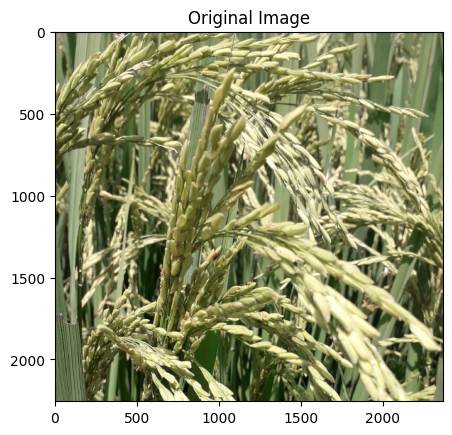

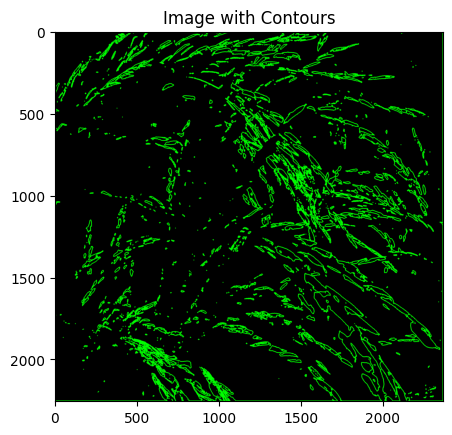

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image using OpenCV
img_path = r'D:\sem7\project\Rice_Seed_Dataset\Healthy_Images\healthy (245).jpg'
img = cv2.imread(img_path)

# Check if the image is loaded successfully
if img is None:
    print("Error: Image not loaded.")
else:
    # Display the original image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.show()

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to the image
    _, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw the contours
    contour_img = np.zeros_like(img)

    # Draw the contours on the image
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)

    # Convert the image to RGB
    contour_img = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)

    # Display the image with contours
    plt.imshow(contour_img)
    plt.title('Image with Contours')
    plt.show()

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize

In [17]:
!pip install lime

In [23]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (245).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = mobinet_example_model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")


1/1 [==============================] - 0s 154ms/step
Accuracy of this prediction is 0.51278824


1/1 [==============================] - 0s 50ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 20/1000 [00:00<00:06, 150.15it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 40/1000 [00:00<00:06, 144.61it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 60/1000 [00:00<00:06, 139.12it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 80/1000 [00:00<00:06, 146.78it/s]

1/1 [==============================] - 0s 43ms/step


 10%|▉         | 95/1000 [00:00<00:06, 134.69it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 110/1000 [00:00<00:07, 126.10it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 130/1000 [00:00<00:06, 136.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 150/1000 [00:01<00:06, 137.58it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 170/1000 [00:01<00:05, 139.91it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 190/1000 [00:01<00:05, 141.60it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 210/1000 [00:01<00:05, 146.83it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▎       | 225/1000 [00:01<00:05, 135.04it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 240/1000 [00:01<00:06, 120.35it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 253/1000 [00:01<00:06, 121.79it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 270/1000 [00:02<00:05, 122.19it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 290/1000 [00:02<00:05, 133.38it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 310/1000 [00:02<00:05, 134.16it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 330/1000 [00:02<00:04, 139.10it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 350/1000 [00:02<00:04, 137.71it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 370/1000 [00:02<00:05, 123.49it/s]

1/1 [==============================] - 0s 7ms/step


 39%|███▉      | 390/1000 [00:02<00:04, 132.35it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 410/1000 [00:03<00:04, 144.65it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 430/1000 [00:03<00:03, 147.13it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 450/1000 [00:03<00:03, 152.31it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 470/1000 [00:03<00:03, 152.62it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 490/1000 [00:03<00:03, 156.46it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 510/1000 [00:03<00:03, 154.50it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 530/1000 [00:03<00:03, 153.25it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 550/1000 [00:03<00:02, 153.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 570/1000 [00:04<00:02, 152.87it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 590/1000 [00:04<00:02, 152.88it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:04<00:02, 144.86it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 630/1000 [00:04<00:02, 141.39it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 650/1000 [00:04<00:02, 142.25it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 670/1000 [00:04<00:02, 140.65it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 690/1000 [00:04<00:02, 138.69it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 710/1000 [00:05<00:02, 142.02it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 730/1000 [00:05<00:01, 150.06it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 750/1000 [00:05<00:01, 149.99it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 770/1000 [00:05<00:01, 156.15it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 790/1000 [00:05<00:01, 153.56it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 810/1000 [00:05<00:01, 150.96it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 830/1000 [00:05<00:01, 151.45it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 846/1000 [00:05<00:01, 152.89it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 862/1000 [00:06<00:01, 132.02it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 880/1000 [00:06<00:00, 123.74it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 900/1000 [00:06<00:00, 126.73it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 913/1000 [00:06<00:00, 127.12it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 930/1000 [00:06<00:00, 119.01it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 950/1000 [00:06<00:00, 127.65it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 970/1000 [00:06<00:00, 134.09it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 990/1000 [00:07<00:00, 139.94it/s]

1/1 [==============================] - 0s 32ms/step


100%|██████████| 1000/1000 [00:07<00:00, 140.13it/s]


(-0.5, 99.5, 99.5, -0.5)

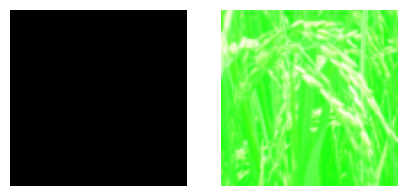

In [64]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (201).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {confidence:.2f}")


from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 118ms/step
Predicted class: 0, Confidence: 0.50


d:\sem 5\New folder\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 20/1000 [00:00<00:08, 121.63it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 40/1000 [00:00<00:07, 125.02it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 60/1000 [00:00<00:07, 132.25it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 80/1000 [00:00<00:06, 134.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 100/1000 [00:00<00:06, 129.16it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 120/1000 [00:00<00:07, 119.97it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 133/1000 [00:01<00:07, 120.50it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 147/1000 [00:01<00:06, 124.13it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 160/1000 [00:01<00:08, 103.50it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 171/1000 [00:01<00:08, 103.23it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 182/1000 [00:01<00:07, 102.44it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 200/1000 [00:01<00:08, 91.42it/s] 

1/1 [==============================] - 0s 59ms/step


 21%|██        | 210/1000 [00:01<00:09, 79.33it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 230/1000 [00:02<00:08, 87.70it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 240/1000 [00:02<00:08, 88.34it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 250/1000 [00:02<00:08, 87.26it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 260/1000 [00:02<00:08, 89.27it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 270/1000 [00:02<00:08, 90.90it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 286/1000 [00:02<00:06, 107.61it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 298/1000 [00:02<00:06, 109.49it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 310/1000 [00:03<00:08, 83.18it/s] 

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 320/1000 [00:03<00:08, 84.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 336/1000 [00:03<00:06, 102.35it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 348/1000 [00:03<00:06, 102.74it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 359/1000 [00:03<00:06, 96.87it/s] 

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 370/1000 [00:03<00:07, 80.71it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 380/1000 [00:03<00:07, 79.77it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 390/1000 [00:03<00:07, 77.23it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 406/1000 [00:04<00:06, 96.51it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 417/1000 [00:04<00:06, 96.13it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 428/1000 [00:04<00:05, 97.72it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 440/1000 [00:04<00:06, 82.83it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 460/1000 [00:04<00:06, 81.89it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 470/1000 [00:04<00:06, 81.79it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:04<00:06, 83.36it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 490/1000 [00:05<00:06, 79.17it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:05<00:06, 81.99it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 520/1000 [00:05<00:05, 85.30it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 530/1000 [00:05<00:05, 80.52it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 540/1000 [00:05<00:05, 78.43it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 550/1000 [00:05<00:05, 76.63it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 560/1000 [00:06<00:05, 74.32it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 570/1000 [00:06<00:05, 75.83it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 580/1000 [00:06<00:05, 75.05it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 590/1000 [00:06<00:05, 68.99it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 600/1000 [00:06<00:06, 64.66it/s]

1/1 [==============================] - 0s 77ms/step


 61%|██████    | 610/1000 [00:06<00:06, 56.10it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 620/1000 [00:07<00:07, 53.75it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 630/1000 [00:07<00:06, 57.93it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 640/1000 [00:07<00:05, 61.35it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 650/1000 [00:07<00:05, 65.57it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 660/1000 [00:07<00:05, 66.91it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 670/1000 [00:07<00:04, 67.47it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 680/1000 [00:07<00:04, 73.66it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 690/1000 [00:08<00:04, 75.05it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 700/1000 [00:08<00:03, 76.28it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████   | 710/1000 [00:08<00:05, 54.27it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 720/1000 [00:08<00:04, 56.64it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 730/1000 [00:08<00:04, 62.06it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 740/1000 [00:08<00:04, 59.36it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 64.25it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 760/1000 [00:09<00:03, 68.08it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 770/1000 [00:09<00:03, 66.51it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 780/1000 [00:09<00:03, 68.08it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 790/1000 [00:09<00:03, 69.31it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 800/1000 [00:09<00:02, 68.94it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 810/1000 [00:09<00:02, 67.60it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 68.32it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 74.12it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 840/1000 [00:10<00:02, 75.58it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 76.74it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 77.12it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 877/1000 [00:10<00:01, 100.10it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 888/1000 [00:10<00:01, 99.09it/s] 

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 899/1000 [00:10<00:01, 97.71it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 54.96it/s]

1/1 [==============================] - 0s 108ms/step


 92%|█████████▏| 920/1000 [00:11<00:01, 48.60it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 930/1000 [00:11<00:01, 47.14it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 940/1000 [00:11<00:01, 48.21it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 50.87it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 51.98it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 54.75it/s]

1/1 [==============================] - 0s 285ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 36.59it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 39.55it/s]

1/1 [==============================] - 0s 58ms/step


100%|██████████| 1000/1000 [00:13<00:00, 74.79it/s]


(-0.5, 99.5, 99.5, -0.5)

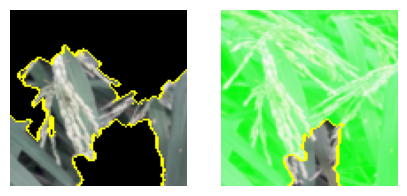

In [18]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100, 100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Specify the URL of the image
url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (225).jpg'

# Read and transform the image
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")


from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 28ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 20/1000 [00:00<00:06, 149.69it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 40/1000 [00:00<00:05, 161.66it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:06, 156.02it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 80/1000 [00:00<00:05, 161.80it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 100/1000 [00:00<00:05, 159.52it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 120/1000 [00:00<00:05, 161.46it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 140/1000 [00:00<00:05, 164.48it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 160/1000 [00:01<00:05, 159.49it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 180/1000 [00:01<00:05, 162.95it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 200/1000 [00:01<00:04, 165.68it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 220/1000 [00:01<00:04, 160.42it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 240/1000 [00:01<00:04, 163.61it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 260/1000 [00:01<00:04, 159.40it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 280/1000 [00:01<00:04, 162.83it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 300/1000 [00:01<00:04, 165.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:04, 160.52it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 340/1000 [00:02<00:04, 163.64it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 360/1000 [00:02<00:03, 165.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 380/1000 [00:02<00:03, 160.89it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 400/1000 [00:02<00:03, 170.20it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 420/1000 [00:02<00:03, 164.25it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 440/1000 [00:02<00:03, 166.30it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 460/1000 [00:02<00:03, 167.84it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 480/1000 [00:02<00:03, 168.86it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 500/1000 [00:03<00:03, 163.00it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 520/1000 [00:03<00:02, 172.12it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 540/1000 [00:03<00:02, 164.95it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 560/1000 [00:03<00:02, 163.75it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 580/1000 [00:03<00:02, 169.02it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 600/1000 [00:03<00:02, 162.99it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 620/1000 [00:03<00:02, 165.49it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 640/1000 [00:03<00:02, 167.08it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 660/1000 [00:04<00:02, 165.79it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 680/1000 [00:04<00:01, 163.35it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 700/1000 [00:04<00:01, 165.58it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 720/1000 [00:04<00:01, 167.25it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 740/1000 [00:04<00:01, 168.56it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 760/1000 [00:04<00:01, 162.59it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 780/1000 [00:04<00:01, 150.63it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 800/1000 [00:04<00:01, 145.31it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 820/1000 [00:05<00:01, 146.56it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 840/1000 [00:05<00:01, 142.71it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 860/1000 [00:05<00:01, 139.51it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:05<00:00, 138.50it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 900/1000 [00:05<00:00, 141.04it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 920/1000 [00:05<00:00, 143.53it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 940/1000 [00:05<00:00, 140.52it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 960/1000 [00:06<00:00, 138.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 980/1000 [00:06<00:00, 141.71it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 1000/1000 [00:06<00:00, 156.99it/s]


(-0.5, 99.5, 99.5, -0.5)

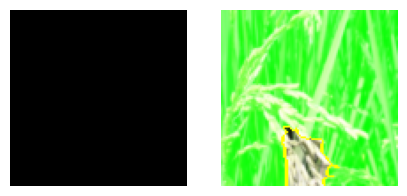

In [66]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (250).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")


from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 29ms/step
Predicted class: 0, Confidence: [[0.4972953]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 20/1000 [00:00<00:08, 109.19it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 31/1000 [00:00<00:08, 108.50it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 50/1000 [00:00<00:08, 115.20it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 70/1000 [00:00<00:07, 121.55it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 90/1000 [00:00<00:07, 121.32it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 110/1000 [00:00<00:07, 124.85it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 130/1000 [00:01<00:06, 125.27it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 150/1000 [00:01<00:07, 119.39it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 162/1000 [00:01<00:07, 113.52it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 180/1000 [00:01<00:07, 109.02it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 200/1000 [00:01<00:07, 113.96it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 220/1000 [00:01<00:06, 121.25it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 240/1000 [00:01<00:05, 130.24it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 260/1000 [00:02<00:05, 137.54it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 280/1000 [00:02<00:05, 135.51it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 300/1000 [00:02<00:04, 140.11it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 320/1000 [00:02<00:04, 143.25it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 340/1000 [00:02<00:04, 147.50it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 151.06it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 139.75it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 400/1000 [00:03<00:04, 129.16it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 126.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 132.57it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 460/1000 [00:03<00:04, 132.95it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 137.58it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 500/1000 [00:03<00:03, 141.32it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 520/1000 [00:03<00:03, 138.63it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 134.84it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▌    | 554/1000 [00:04<00:03, 128.71it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 570/1000 [00:04<00:03, 117.72it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 590/1000 [00:04<00:03, 112.08it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:04<00:03, 111.10it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 630/1000 [00:04<00:03, 112.98it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 650/1000 [00:05<00:03, 115.15it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 670/1000 [00:05<00:02, 116.64it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 123.01it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 710/1000 [00:05<00:02, 126.10it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 730/1000 [00:05<00:02, 128.05it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 750/1000 [00:05<00:01, 129.95it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 770/1000 [00:06<00:01, 135.01it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 790/1000 [00:06<00:01, 134.51it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 810/1000 [00:06<00:01, 136.45it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 133.53it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 134.49it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 870/1000 [00:06<00:01, 129.96it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 890/1000 [00:06<00:00, 126.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 124.78it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 116.38it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 950/1000 [00:07<00:00, 113.72it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 962/1000 [00:07<00:00, 111.37it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 974/1000 [00:07<00:00, 107.15it/s]

1/1 [==============================] - 0s 64ms/step


 99%|█████████▉| 990/1000 [00:07<00:00, 99.03it/s] 

1/1 [==============================] - 0s 33ms/step


100%|██████████| 1000/1000 [00:08<00:00, 124.04it/s]


(-0.5, 99.5, 99.5, -0.5)

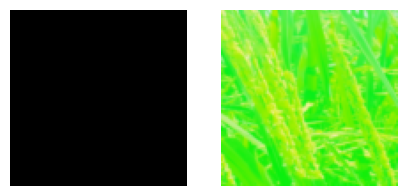

In [20]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (360).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")


from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 42ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 10/1000 [00:00<00:14, 66.92it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 20/1000 [00:00<00:12, 76.90it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 30/1000 [00:00<00:13, 73.91it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 40/1000 [00:00<00:12, 74.91it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 50/1000 [00:00<00:12, 78.82it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 70/1000 [00:00<00:11, 84.03it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 80/1000 [00:01<00:11, 80.30it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 90/1000 [00:01<00:11, 82.38it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 100/1000 [00:01<00:10, 85.13it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 110/1000 [00:01<00:10, 85.42it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 120/1000 [00:01<00:10, 83.54it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 130/1000 [00:01<00:10, 83.68it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 84.37it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 150/1000 [00:01<00:09, 86.19it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 160/1000 [00:01<00:09, 89.21it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 170/1000 [00:02<00:09, 90.20it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 180/1000 [00:02<00:09, 90.36it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 82.11it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 200/1000 [00:02<00:20, 39.75it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 210/1000 [00:02<00:16, 48.21it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 220/1000 [00:03<00:13, 55.76it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 230/1000 [00:03<00:12, 61.83it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 240/1000 [00:03<00:11, 68.53it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 253/1000 [00:03<00:09, 82.44it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 264/1000 [00:03<00:08, 88.98it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 275/1000 [00:03<00:08, 88.51it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 285/1000 [00:03<00:08, 86.38it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 295/1000 [00:03<00:08, 80.99it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 307/1000 [00:03<00:07, 90.61it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 317/1000 [00:04<00:07, 91.90it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 327/1000 [00:04<00:07, 93.53it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 337/1000 [00:04<00:07, 88.40it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 347/1000 [00:04<00:07, 86.21it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 356/1000 [00:04<00:07, 81.28it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 365/1000 [00:04<00:07, 80.07it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 374/1000 [00:04<00:07, 79.52it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 383/1000 [00:04<00:08, 76.18it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 391/1000 [00:05<00:08, 73.58it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 400/1000 [00:05<00:08, 73.15it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 410/1000 [00:05<00:08, 73.19it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 74.73it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 77.61it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 80.55it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 83.16it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 79.46it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 84.35it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 85.80it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 500/1000 [00:06<00:05, 94.78it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 510/1000 [00:06<00:05, 92.01it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 520/1000 [00:06<00:05, 88.12it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 84.40it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 84.61it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 85.89it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 560/1000 [00:07<00:04, 88.23it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 570/1000 [00:07<00:04, 90.35it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 580/1000 [00:07<00:04, 90.54it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 590/1000 [00:07<00:04, 87.12it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 600/1000 [00:07<00:04, 82.03it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 610/1000 [00:07<00:04, 80.03it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 80.87it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 85.54it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 640/1000 [00:07<00:04, 84.09it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 81.63it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 82.37it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 670/1000 [00:08<00:03, 85.24it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 680/1000 [00:08<00:03, 88.89it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 91.48it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 700/1000 [00:08<00:03, 87.69it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 710/1000 [00:08<00:03, 87.18it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 720/1000 [00:08<00:03, 89.63it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 86.44it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 80.87it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 80.88it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 83.02it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 80.17it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 80.93it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 84.75it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 800/1000 [00:09<00:02, 84.64it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 810/1000 [00:09<00:02, 85.33it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 88.53it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 830/1000 [00:10<00:01, 87.35it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 846/1000 [00:10<00:01, 106.93it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 857/1000 [00:10<00:01, 101.61it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 868/1000 [00:10<00:01, 95.49it/s] 

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 878/1000 [00:10<00:01, 91.66it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 888/1000 [00:10<00:01, 85.51it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 897/1000 [00:10<00:01, 80.92it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 906/1000 [00:11<00:01, 77.37it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 914/1000 [00:11<00:01, 77.08it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 74.90it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 77.88it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 78.01it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 960/1000 [00:11<00:00, 82.04it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 973/1000 [00:11<00:00, 93.88it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 983/1000 [00:11<00:00, 93.21it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 993/1000 [00:12<00:00, 86.89it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 1000/1000 [00:12<00:00, 81.81it/s]


(-0.5, 99.5, 99.5, -0.5)

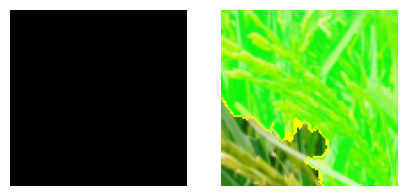

In [68]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (372).jpg'
images = read_and_transform_img(url)
if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 37ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 10/1000 [00:00<00:10, 91.81it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:11, 86.73it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 30/1000 [00:00<00:11, 88.15it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 40/1000 [00:00<00:11, 84.00it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 50/1000 [00:00<00:11, 80.82it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 60/1000 [00:00<00:11, 78.63it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 70/1000 [00:00<00:11, 82.29it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 80/1000 [00:00<00:11, 81.21it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 99/1000 [00:01<00:08, 110.19it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 111/1000 [00:01<00:11, 76.79it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 121/1000 [00:01<00:11, 78.16it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 74.01it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 76.26it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 150/1000 [00:01<00:11, 74.73it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 160/1000 [00:01<00:10, 80.06it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 170/1000 [00:02<00:09, 83.97it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 190/1000 [00:02<00:08, 90.34it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 200/1000 [00:02<00:09, 86.76it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 210/1000 [00:02<00:09, 84.16it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 84.49it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 81.39it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 240/1000 [00:02<00:08, 85.31it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 250/1000 [00:03<00:08, 83.87it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 260/1000 [00:03<00:08, 83.33it/s]

1/1 [==============================] - 0s 48ms/step


 27%|██▋       | 270/1000 [00:03<00:08, 82.51it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 85.64it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 290/1000 [00:03<00:08, 82.59it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 300/1000 [00:03<00:08, 82.50it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 310/1000 [00:03<00:08, 78.17it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 330/1000 [00:03<00:07, 85.37it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 80.89it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 78.97it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 79.31it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 370/1000 [00:04<00:08, 77.72it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 380/1000 [00:04<00:07, 78.07it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 390/1000 [00:04<00:07, 81.43it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 400/1000 [00:04<00:07, 77.88it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 410/1000 [00:05<00:07, 78.41it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 79.42it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 77.29it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 81.52it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 78.68it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 80.94it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 480/1000 [00:05<00:06, 83.75it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 80.09it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:06<00:06, 79.13it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 510/1000 [00:06<00:06, 76.01it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 76.83it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 530/1000 [00:06<00:06, 76.35it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 540/1000 [00:06<00:06, 76.15it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 75.11it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 560/1000 [00:06<00:05, 79.08it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 576/1000 [00:07<00:04, 99.22it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 587/1000 [00:07<00:04, 90.98it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 597/1000 [00:07<00:04, 87.65it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 607/1000 [00:07<00:04, 85.95it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 616/1000 [00:07<00:04, 80.46it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▎   | 625/1000 [00:07<00:04, 78.89it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 633/1000 [00:07<00:04, 75.84it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 641/1000 [00:07<00:04, 73.46it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 650/1000 [00:08<00:05, 69.98it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 71.66it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 72.42it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 680/1000 [00:08<00:04, 74.03it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 690/1000 [00:08<00:04, 76.80it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 700/1000 [00:08<00:03, 76.94it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 710/1000 [00:08<00:03, 78.03it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 720/1000 [00:08<00:03, 80.52it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 79.16it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 745/1000 [00:09<00:02, 97.01it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 756/1000 [00:09<00:02, 92.93it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 766/1000 [00:09<00:02, 85.91it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 775/1000 [00:09<00:02, 81.27it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 784/1000 [00:09<00:02, 80.21it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 793/1000 [00:09<00:02, 76.15it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 801/1000 [00:09<00:02, 70.42it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 810/1000 [00:10<00:02, 70.67it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 70.55it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 72.52it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 840/1000 [00:10<00:02, 76.39it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 79.04it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 81.96it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 82.48it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 880/1000 [00:10<00:01, 79.52it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 81.71it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 78.52it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 78.76it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 920/1000 [00:11<00:01, 70.58it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 74.49it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 74.54it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 73.10it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 74.49it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 75.57it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 73.00it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 74.14it/s]

1/1 [==============================] - 0s 43ms/step


100%|██████████| 1000/1000 [00:12<00:00, 79.62it/s]


(-0.5, 99.5, 99.5, -0.5)

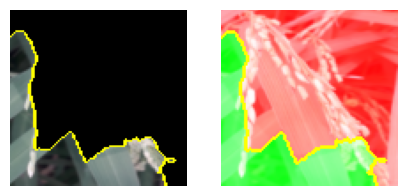

In [69]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (220).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 23ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 20/1000 [00:00<00:05, 163.65it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 40/1000 [00:00<00:06, 156.93it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 60/1000 [00:00<00:05, 159.45it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 80/1000 [00:00<00:06, 148.60it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 100/1000 [00:00<00:06, 141.06it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 120/1000 [00:00<00:06, 134.12it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 140/1000 [00:00<00:06, 142.12it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 160/1000 [00:01<00:05, 141.18it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 180/1000 [00:01<00:05, 144.19it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 200/1000 [00:01<00:05, 144.75it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 220/1000 [00:01<00:05, 146.19it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 240/1000 [00:01<00:05, 148.12it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:01<00:05, 132.82it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 280/1000 [00:01<00:05, 131.58it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 300/1000 [00:02<00:05, 124.83it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 121.51it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 340/1000 [00:02<00:05, 124.50it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 360/1000 [00:02<00:05, 126.55it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 128.39it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 400/1000 [00:02<00:04, 125.42it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 128.29it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 130.08it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 460/1000 [00:03<00:04, 130.33it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 480/1000 [00:03<00:04, 127.72it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 500/1000 [00:03<00:03, 126.20it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 513/1000 [00:03<00:04, 114.44it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 530/1000 [00:04<00:04, 114.55it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 550/1000 [00:04<00:03, 116.92it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 570/1000 [00:04<00:03, 119.25it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 590/1000 [00:04<00:03, 118.04it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 610/1000 [00:04<00:03, 118.12it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 630/1000 [00:04<00:03, 119.83it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 650/1000 [00:05<00:02, 123.56it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 670/1000 [00:05<00:02, 124.89it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 126.92it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 710/1000 [00:05<00:02, 113.41it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 722/1000 [00:05<00:02, 112.94it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 734/1000 [00:05<00:02, 111.74it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▍  | 746/1000 [00:05<00:02, 101.70it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 757/1000 [00:06<00:02, 96.13it/s] 

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 770/1000 [00:06<00:02, 87.27it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 790/1000 [00:06<00:02, 92.90it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 810/1000 [00:06<00:01, 96.45it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 102.19it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 107.11it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 870/1000 [00:07<00:01, 105.82it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 881/1000 [00:07<00:01, 99.63it/s] 

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 900/1000 [00:07<00:01, 85.83it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 910/1000 [00:07<00:01, 81.67it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 920/1000 [00:07<00:00, 83.37it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 81.08it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 950/1000 [00:08<00:00, 92.32it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 970/1000 [00:08<00:00, 99.71it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 990/1000 [00:08<00:00, 104.12it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 1000/1000 [00:08<00:00, 116.49it/s]


(-0.5, 99.5, 99.5, -0.5)

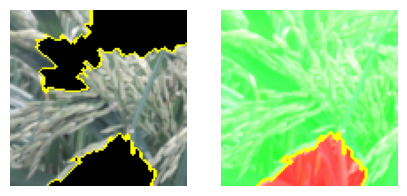

In [78]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Healthy_Images/healthy (415).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 45ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 10/1000 [00:00<00:12, 80.83it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 29/1000 [00:00<00:06, 139.09it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 44/1000 [00:00<00:11, 86.60it/s] 

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 55/1000 [00:00<00:10, 92.45it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 66/1000 [00:00<00:10, 90.04it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 76/1000 [00:00<00:10, 86.44it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 86/1000 [00:00<00:10, 86.23it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 95/1000 [00:01<00:10, 85.42it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 104/1000 [00:01<00:11, 80.96it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█▏        | 113/1000 [00:01<00:11, 75.03it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 121/1000 [00:01<00:12, 69.69it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 68.29it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 73.33it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 150/1000 [00:01<00:11, 76.24it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 160/1000 [00:01<00:11, 76.05it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 75.52it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 79.68it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 82.61it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 210/1000 [00:02<00:09, 86.63it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 84.50it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 82.73it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 240/1000 [00:02<00:09, 81.93it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 78.62it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 80.39it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 81.02it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 77.01it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 77.99it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 308/1000 [00:03<00:06, 103.09it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 319/1000 [00:03<00:07, 93.79it/s] 

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 329/1000 [00:03<00:07, 86.90it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 339/1000 [00:04<00:07, 88.02it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 349/1000 [00:04<00:07, 85.17it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 358/1000 [00:04<00:07, 84.79it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 367/1000 [00:04<00:07, 81.49it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 376/1000 [00:04<00:08, 77.51it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 384/1000 [00:04<00:08, 73.15it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 392/1000 [00:04<00:08, 68.40it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 400/1000 [00:04<00:08, 67.80it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 410/1000 [00:05<00:08, 70.66it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 77.97it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 430/1000 [00:05<00:06, 83.25it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 80.60it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 450/1000 [00:05<00:07, 78.52it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 79.81it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 77.58it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 480/1000 [00:05<00:06, 75.62it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 79.81it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 500/1000 [00:06<00:06, 77.58it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 510/1000 [00:06<00:06, 80.21it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 79.11it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 530/1000 [00:06<00:06, 78.21it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 78.09it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 81.00it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 560/1000 [00:06<00:05, 81.31it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 83.31it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 80.50it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 590/1000 [00:07<00:04, 84.07it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 600/1000 [00:07<00:04, 82.25it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 610/1000 [00:07<00:04, 83.31it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 82.04it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 86.25it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 640/1000 [00:07<00:04, 88.02it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 650/1000 [00:07<00:04, 86.50it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 80.76it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 80.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 684/1000 [00:08<00:03, 95.94it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 694/1000 [00:08<00:03, 88.04it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 704/1000 [00:08<00:03, 89.01it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 714/1000 [00:08<00:03, 88.95it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 724/1000 [00:08<00:03, 84.94it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 733/1000 [00:08<00:03, 83.40it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 742/1000 [00:09<00:03, 80.33it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 751/1000 [00:09<00:03, 75.40it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 760/1000 [00:09<00:03, 78.34it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 81.81it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 82.47it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 81.93it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 800/1000 [00:09<00:02, 79.38it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 810/1000 [00:09<00:02, 82.84it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 84.66it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 830/1000 [00:10<00:01, 88.37it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 91.34it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 87.35it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 87.82it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 80.81it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 880/1000 [00:10<00:01, 81.49it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 890/1000 [00:10<00:01, 79.93it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 900/1000 [00:10<00:01, 81.89it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 81.60it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 920/1000 [00:11<00:01, 77.79it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 81.40it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 85.40it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 89.03it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 960/1000 [00:11<00:00, 84.97it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 970/1000 [00:11<00:00, 84.90it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 980/1000 [00:11<00:00, 81.61it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 81.41it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 1000/1000 [00:12<00:00, 82.15it/s]


(-0.5, 99.5, 99.5, -0.5)

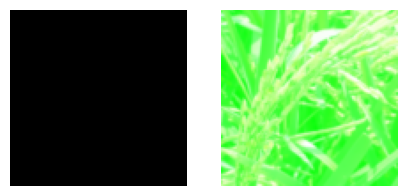

In [70]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (312).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 44ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 10/1000 [00:00<00:12, 77.37it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 20/1000 [00:00<00:12, 76.82it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 30/1000 [00:00<00:11, 84.22it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 40/1000 [00:00<00:11, 80.81it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 50/1000 [00:00<00:11, 83.74it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 60/1000 [00:00<00:11, 83.25it/s]

1/1 [==============================] - 0s 52ms/step


  7%|▋         | 70/1000 [00:00<00:12, 77.19it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 80/1000 [00:01<00:11, 77.89it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 90/1000 [00:01<00:11, 78.32it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 100/1000 [00:01<00:11, 79.51it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 110/1000 [00:01<00:11, 77.18it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 76.48it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 130/1000 [00:01<00:10, 80.26it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 82.30it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 150/1000 [00:01<00:10, 80.20it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 79.96it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 81.52it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 79.95it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 81.87it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 200/1000 [00:02<00:10, 77.71it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 210/1000 [00:02<00:10, 76.37it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 80.47it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 79.36it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 77.33it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 76.18it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 74.73it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 76.80it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 75.27it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 77.61it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 300/1000 [00:03<00:09, 77.61it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 310/1000 [00:03<00:08, 78.10it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 76.87it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 76.95it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 77.97it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 76.01it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 72.95it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 370/1000 [00:04<00:08, 72.93it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 380/1000 [00:04<00:08, 74.64it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 73.44it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 400/1000 [00:05<00:08, 73.17it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 410/1000 [00:05<00:07, 76.80it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 426/1000 [00:05<00:05, 97.31it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 437/1000 [00:05<00:06, 91.81it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 447/1000 [00:05<00:06, 85.78it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 456/1000 [00:05<00:06, 78.92it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 465/1000 [00:05<00:06, 77.30it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 473/1000 [00:06<00:07, 70.69it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 481/1000 [00:06<00:07, 65.83it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 490/1000 [00:06<00:07, 68.92it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 500/1000 [00:06<00:06, 74.10it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 510/1000 [00:06<00:06, 75.40it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 79.21it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 80.88it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 81.15it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 550/1000 [00:07<00:05, 78.95it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 79.90it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 76.81it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 75.85it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 81.31it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 600/1000 [00:07<00:04, 83.48it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 610/1000 [00:07<00:04, 86.28it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 84.66it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 630/1000 [00:08<00:04, 83.59it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 83.53it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 84.23it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 80.13it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 81.11it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 680/1000 [00:08<00:03, 81.45it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 82.34it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 700/1000 [00:08<00:03, 84.62it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 710/1000 [00:08<00:03, 84.43it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 87.23it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 87.40it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 740/1000 [00:09<00:02, 86.84it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 750/1000 [00:09<00:02, 84.56it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 82.84it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 85.40it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 83.85it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 83.55it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 800/1000 [00:10<00:02, 82.81it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 810/1000 [00:10<00:02, 80.91it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 80.69it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 82.36it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 840/1000 [00:10<00:02, 77.46it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 850/1000 [00:10<00:02, 73.41it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 76.81it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 76.34it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 80.91it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 73.81it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 71.03it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 920/1000 [00:11<00:00, 88.07it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 937/1000 [00:11<00:00, 106.39it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 93.68it/s] 

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 960/1000 [00:11<00:00, 92.32it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 87.89it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 86.97it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 86.86it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 1000/1000 [00:12<00:00, 80.62it/s]


(-0.5, 99.5, 99.5, -0.5)

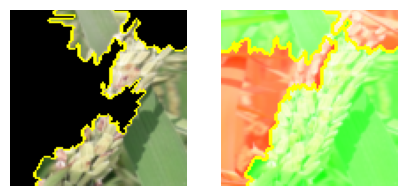

In [71]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (270).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 46ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 12/1000 [00:00<00:08, 119.10it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 24/1000 [00:00<00:09, 100.17it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 35/1000 [00:00<00:10, 92.48it/s] 

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 45/1000 [00:00<00:11, 85.77it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 54/1000 [00:00<00:12, 76.17it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▌         | 62/1000 [00:00<00:13, 67.52it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 70/1000 [00:00<00:14, 63.63it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 80/1000 [00:01<00:12, 70.80it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 93/1000 [00:01<00:10, 85.94it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 103/1000 [00:01<00:10, 87.12it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█▏        | 113/1000 [00:01<00:10, 82.44it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 122/1000 [00:01<00:10, 82.19it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 131/1000 [00:01<00:11, 77.44it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 77.26it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 150/1000 [00:01<00:10, 80.35it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 160/1000 [00:01<00:10, 83.15it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 170/1000 [00:02<00:09, 83.16it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 180/1000 [00:02<00:09, 82.09it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 83.33it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 200/1000 [00:02<00:10, 79.67it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 210/1000 [00:02<00:09, 81.02it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 81.00it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 85.27it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 240/1000 [00:02<00:09, 80.99it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 79.42it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 79.87it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 77.78it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 81.06it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 78.13it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 300/1000 [00:03<00:09, 76.89it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 310/1000 [00:03<00:08, 79.57it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 320/1000 [00:03<00:08, 79.31it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 77.27it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 349/1000 [00:04<00:06, 105.25it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 361/1000 [00:04<00:08, 79.38it/s] 

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 371/1000 [00:04<00:07, 80.90it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 381/1000 [00:04<00:07, 84.23it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 391/1000 [00:04<00:07, 85.48it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 401/1000 [00:04<00:06, 87.84it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 411/1000 [00:05<00:06, 86.51it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 420/1000 [00:05<00:06, 82.96it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 80.75it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 440/1000 [00:05<00:07, 79.34it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 81.32it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 79.37it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 77.37it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 480/1000 [00:05<00:06, 75.32it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 76.35it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 500/1000 [00:06<00:06, 79.56it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 510/1000 [00:06<00:06, 74.78it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 74.28it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 530/1000 [00:06<00:06, 74.67it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 77.33it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 75.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 560/1000 [00:06<00:05, 74.62it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 75.74it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 75.27it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 74.75it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 600/1000 [00:07<00:05, 77.33it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 610/1000 [00:07<00:05, 76.35it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 620/1000 [00:07<00:05, 74.69it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 76.39it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 77.69it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 78.54it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 78.59it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 81.50it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 680/1000 [00:08<00:03, 81.30it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 698/1000 [00:08<00:02, 106.63it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 710/1000 [00:08<00:03, 86.96it/s] 

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 720/1000 [00:08<00:03, 86.17it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 84.84it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 80.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 82.57it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 760/1000 [00:09<00:03, 78.82it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 77.84it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 78.31it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 77.43it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 800/1000 [00:09<00:02, 80.88it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 810/1000 [00:10<00:02, 82.21it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 830/1000 [00:10<00:01, 91.79it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 91.05it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 88.57it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 86.78it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 890/1000 [00:10<00:01, 87.69it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 84.15it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 84.38it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 926/1000 [00:11<00:00, 101.39it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 937/1000 [00:11<00:00, 90.48it/s] 

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 947/1000 [00:11<00:00, 88.77it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 957/1000 [00:11<00:00, 87.59it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 966/1000 [00:11<00:00, 84.42it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 975/1000 [00:11<00:00, 81.77it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 984/1000 [00:12<00:00, 76.10it/s]

1/1 [==============================] - 0s 46ms/step


100%|██████████| 1000/1000 [00:12<00:00, 81.26it/s]


(-0.5, 99.5, 99.5, -0.5)

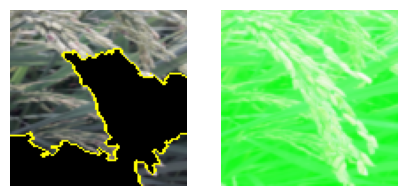

In [72]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (284).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 48ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 10/1000 [00:00<00:12, 76.88it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 24/1000 [00:00<00:08, 109.73it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 40/1000 [00:00<00:10, 87.95it/s] 

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 52/1000 [00:00<00:09, 97.00it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 63/1000 [00:00<00:09, 98.69it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 74/1000 [00:00<00:10, 91.71it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 90/1000 [00:01<00:10, 85.14it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 100/1000 [00:01<00:10, 88.46it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 110/1000 [00:01<00:10, 84.38it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 120/1000 [00:01<00:10, 80.40it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 130/1000 [00:01<00:10, 80.53it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 141/1000 [00:01<00:09, 87.74it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 151/1000 [00:01<00:10, 84.51it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 160/1000 [00:01<00:09, 85.47it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 170/1000 [00:01<00:09, 85.92it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 81.34it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 190/1000 [00:02<00:10, 80.39it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 200/1000 [00:02<00:09, 80.48it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 210/1000 [00:02<00:10, 77.57it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 220/1000 [00:02<00:10, 75.07it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 78.07it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 240/1000 [00:02<00:09, 77.56it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 74.93it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 74.79it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 72.56it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 280/1000 [00:03<00:10, 71.86it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 74.25it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 300/1000 [00:03<00:09, 75.10it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 310/1000 [00:03<00:08, 77.23it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 320/1000 [00:03<00:08, 76.41it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 75.93it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 76.12it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 75.35it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 78.63it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 370/1000 [00:04<00:07, 82.07it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 380/1000 [00:04<00:07, 78.45it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 390/1000 [00:04<00:07, 78.09it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 400/1000 [00:04<00:07, 76.79it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 410/1000 [00:05<00:07, 75.41it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 73.08it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 78.88it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 82.82it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 450/1000 [00:05<00:07, 77.77it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 77.73it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 76.54it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 480/1000 [00:05<00:06, 81.69it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 80.56it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 500/1000 [00:06<00:06, 75.85it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 510/1000 [00:06<00:06, 79.76it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 74.91it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 530/1000 [00:06<00:06, 77.87it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 540/1000 [00:06<00:06, 75.76it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 550/1000 [00:06<00:06, 74.33it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 75.86it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 74.31it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 71.54it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 73.46it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 600/1000 [00:07<00:05, 73.34it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 610/1000 [00:07<00:05, 74.51it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 620/1000 [00:07<00:05, 73.76it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 72.63it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 74.25it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 73.91it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 72.64it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 75.19it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 680/1000 [00:08<00:04, 78.37it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 81.49it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 700/1000 [00:08<00:03, 79.83it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 710/1000 [00:09<00:03, 79.11it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 76.80it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 75.07it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 74.59it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 72.52it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 760/1000 [00:09<00:03, 71.90it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 770/1000 [00:09<00:03, 73.17it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 75.81it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 790/1000 [00:10<00:02, 75.93it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 800/1000 [00:10<00:02, 74.03it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 810/1000 [00:10<00:02, 77.39it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 75.10it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 76.85it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 840/1000 [00:10<00:02, 75.99it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 76.97it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 860/1000 [00:11<00:01, 75.38it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 870/1000 [00:11<00:01, 74.97it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 72.84it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 76.77it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 76.18it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 76.89it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 920/1000 [00:11<00:01, 73.52it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 74.99it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 940/1000 [00:12<00:00, 74.68it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 74.10it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 72.32it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 73.59it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 77.54it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 993/1000 [00:12<00:00, 90.44it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 1000/1000 [00:12<00:00, 77.93it/s]


(-0.5, 99.5, 99.5, -0.5)

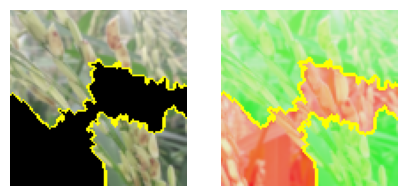

In [73]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (297).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 47ms/step
Accuracy of this prediction is 0.49867502


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 10/1000 [00:00<00:13, 75.86it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 20/1000 [00:00<00:12, 76.31it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 36/1000 [00:00<00:08, 109.00it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 48/1000 [00:00<00:08, 109.88it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 60/1000 [00:00<00:11, 79.75it/s] 

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 70/1000 [00:00<00:12, 77.30it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 80/1000 [00:00<00:12, 75.14it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 90/1000 [00:01<00:11, 76.89it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 100/1000 [00:01<00:11, 77.38it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 110/1000 [00:01<00:11, 75.67it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 77.79it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 78.38it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 76.05it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 150/1000 [00:01<00:11, 74.29it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 77.96it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 170/1000 [00:02<00:09, 83.19it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 78.24it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 190/1000 [00:02<00:10, 77.20it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 200/1000 [00:02<00:10, 78.44it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 210/1000 [00:02<00:10, 76.48it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 220/1000 [00:02<00:10, 77.37it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 77.19it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 78.34it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 255/1000 [00:03<00:07, 96.19it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▋       | 265/1000 [00:03<00:08, 90.19it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 275/1000 [00:03<00:08, 88.10it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 285/1000 [00:03<00:08, 83.41it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 294/1000 [00:03<00:08, 81.21it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 303/1000 [00:03<00:08, 78.31it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 311/1000 [00:03<00:09, 73.62it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 320/1000 [00:03<00:08, 75.67it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 78.69it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 77.20it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 76.60it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 75.30it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 370/1000 [00:04<00:08, 76.40it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 380/1000 [00:04<00:08, 73.81it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 390/1000 [00:04<00:08, 74.20it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 400/1000 [00:05<00:08, 73.09it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 410/1000 [00:05<00:08, 71.85it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 73.73it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 75.77it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 440/1000 [00:05<00:07, 76.29it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 450/1000 [00:05<00:07, 76.18it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 460/1000 [00:05<00:07, 77.11it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 78.94it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 76.12it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 75.14it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:06<00:06, 77.73it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 515/1000 [00:06<00:05, 95.61it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▎    | 525/1000 [00:06<00:05, 93.19it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 535/1000 [00:06<00:05, 90.16it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 545/1000 [00:06<00:05, 89.97it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 555/1000 [00:06<00:04, 91.54it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 565/1000 [00:07<00:04, 91.53it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▊    | 575/1000 [00:07<00:04, 87.36it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 584/1000 [00:07<00:05, 79.37it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 593/1000 [00:07<00:05, 77.32it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 601/1000 [00:07<00:05, 76.21it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 81.20it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 82.14it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 640/1000 [00:07<00:04, 82.73it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 651/1000 [00:08<00:03, 89.27it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 661/1000 [00:08<00:03, 91.17it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 671/1000 [00:08<00:03, 90.70it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 681/1000 [00:08<00:03, 87.10it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 82.32it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 700/1000 [00:08<00:03, 86.40it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 710/1000 [00:08<00:03, 82.55it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 720/1000 [00:08<00:03, 83.94it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 86.21it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 750/1000 [00:09<00:02, 88.83it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 83.45it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 84.13it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 83.78it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 80.47it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 800/1000 [00:09<00:02, 80.56it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 810/1000 [00:09<00:02, 84.62it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 822/1000 [00:10<00:01, 93.66it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 832/1000 [00:10<00:01, 86.88it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 841/1000 [00:10<00:01, 81.38it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 76.00it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 80.81it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 80.52it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:10<00:01, 83.17it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 890/1000 [00:10<00:01, 84.49it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 907/1000 [00:11<00:00, 107.06it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 919/1000 [00:11<00:00, 108.58it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 931/1000 [00:11<00:00, 80.68it/s] 

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 941/1000 [00:11<00:00, 78.77it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 77.18it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 960/1000 [00:11<00:00, 77.54it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 970/1000 [00:11<00:00, 80.71it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 980/1000 [00:11<00:00, 82.15it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 83.06it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 1000/1000 [00:12<00:00, 81.68it/s]


(-0.5, 99.5, 99.5, -0.5)

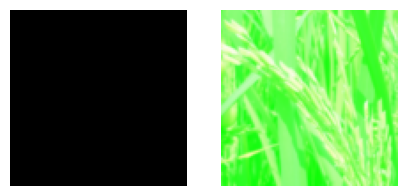

In [74]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (271).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 17ms/step
Predicted class: 0, Confidence: [[0.4972953]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 20/1000 [00:00<00:07, 136.73it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 34/1000 [00:00<00:07, 121.74it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 50/1000 [00:00<00:08, 112.76it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 70/1000 [00:00<00:07, 124.12it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 90/1000 [00:00<00:07, 126.55it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 110/1000 [00:00<00:06, 129.97it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 130/1000 [00:01<00:06, 126.56it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 150/1000 [00:01<00:06, 129.11it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 170/1000 [00:01<00:06, 131.77it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 187/1000 [00:01<00:05, 139.34it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 202/1000 [00:01<00:06, 127.21it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 220/1000 [00:01<00:06, 122.67it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 240/1000 [00:01<00:06, 125.46it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 260/1000 [00:02<00:05, 128.85it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 280/1000 [00:02<00:05, 131.93it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 300/1000 [00:02<00:05, 132.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 130.85it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 340/1000 [00:02<00:05, 131.86it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 135.43it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 125.20it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 400/1000 [00:03<00:04, 125.78it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 127.51it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 129.04it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 460/1000 [00:03<00:04, 127.07it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 480/1000 [00:03<00:04, 128.83it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 500/1000 [00:03<00:04, 121.26it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 517/1000 [00:04<00:03, 131.06it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 531/1000 [00:04<00:03, 121.73it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 544/1000 [00:04<00:03, 119.13it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 557/1000 [00:04<00:03, 119.20it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 570/1000 [00:04<00:03, 109.21it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 590/1000 [00:04<00:03, 115.55it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 610/1000 [00:04<00:03, 109.99it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 630/1000 [00:05<00:03, 107.38it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 641/1000 [00:05<00:03, 105.99it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 660/1000 [00:05<00:03, 110.09it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 680/1000 [00:05<00:02, 111.67it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 700/1000 [00:05<00:02, 111.26it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 720/1000 [00:05<00:02, 111.52it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 740/1000 [00:06<00:02, 112.18it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 760/1000 [00:06<00:02, 106.86it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 771/1000 [00:06<00:02, 105.60it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 790/1000 [00:06<00:01, 109.80it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 810/1000 [00:06<00:01, 117.41it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 125.57it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 127.93it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 870/1000 [00:07<00:01, 125.81it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 890/1000 [00:07<00:00, 127.45it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 121.95it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 129.24it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 950/1000 [00:07<00:00, 129.83it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 970/1000 [00:07<00:00, 131.55it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 990/1000 [00:08<00:00, 141.08it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 1000/1000 [00:08<00:00, 123.68it/s]


(-0.5, 99.5, 99.5, -0.5)

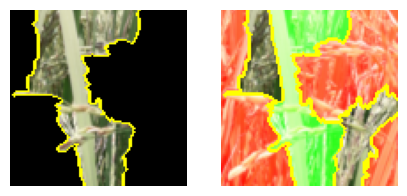

In [22]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (252).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 33ms/step
Predicted class: 0, Confidence: [[0.4972953]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 20/1000 [00:00<00:08, 121.86it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 33/1000 [00:00<00:08, 111.40it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 45/1000 [00:00<00:08, 109.81it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 56/1000 [00:00<00:08, 105.40it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 70/1000 [00:00<00:09, 93.76it/s] 

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 90/1000 [00:00<00:08, 104.82it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 110/1000 [00:01<00:08, 108.21it/s]

1/1 [==============================] - 0s 10ms/step


 13%|█▎        | 130/1000 [00:01<00:07, 113.83it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 150/1000 [00:01<00:07, 113.74it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 170/1000 [00:01<00:07, 113.83it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 190/1000 [00:01<00:06, 119.72it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 210/1000 [00:01<00:06, 117.07it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 230/1000 [00:02<00:06, 112.20it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 250/1000 [00:02<00:06, 114.68it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 265/1000 [00:02<00:06, 121.67it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 278/1000 [00:02<00:05, 122.74it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 291/1000 [00:02<00:06, 102.94it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 302/1000 [00:02<00:07, 91.66it/s] 

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 320/1000 [00:02<00:06, 98.56it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 340/1000 [00:03<00:06, 105.52it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 360/1000 [00:03<00:05, 108.05it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 380/1000 [00:03<00:05, 117.60it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 400/1000 [00:03<00:04, 125.30it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 132.14it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 138.11it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 137.48it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 480/1000 [00:04<00:03, 144.38it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 500/1000 [00:04<00:03, 145.63it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 520/1000 [00:04<00:03, 144.19it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 143.38it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 560/1000 [00:04<00:02, 150.83it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 580/1000 [00:04<00:02, 147.19it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 600/1000 [00:04<00:02, 141.72it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 620/1000 [00:05<00:02, 143.03it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 640/1000 [00:05<00:02, 145.18it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 660/1000 [00:05<00:02, 141.69it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 680/1000 [00:05<00:02, 143.74it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 700/1000 [00:05<00:02, 145.70it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 720/1000 [00:05<00:01, 146.46it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 740/1000 [00:05<00:01, 137.36it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 760/1000 [00:06<00:01, 130.86it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 780/1000 [00:06<00:01, 125.43it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 800/1000 [00:06<00:01, 121.95it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 820/1000 [00:06<00:01, 119.26it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 840/1000 [00:06<00:01, 121.62it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 860/1000 [00:06<00:01, 122.08it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 880/1000 [00:07<00:00, 122.15it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 893/1000 [00:07<00:00, 120.39it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 115.64it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 114.96it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 945/1000 [00:07<00:00, 122.22it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 960/1000 [00:07<00:00, 114.14it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 980/1000 [00:07<00:00, 116.99it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 992/1000 [00:08<00:00, 106.57it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 1000/1000 [00:08<00:00, 122.04it/s]


(-0.5, 99.5, 99.5, -0.5)

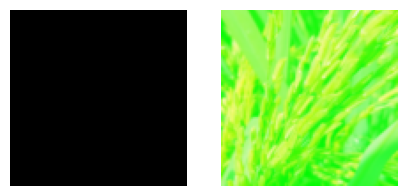

In [23]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (393).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')

1/1 [==============================] - 0s 30ms/step
Accuracy of this prediction is 0.4972953


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 14/1000 [00:00<00:07, 137.14it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 28/1000 [00:00<00:07, 123.61it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▍         | 41/1000 [00:00<00:13, 71.18it/s] 

1/1 [==============================] - 0s 56ms/step


  5%|▌         | 50/1000 [00:00<00:15, 63.24it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 60/1000 [00:00<00:15, 58.77it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 70/1000 [00:01<00:15, 61.78it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 80/1000 [00:01<00:13, 67.13it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 90/1000 [00:01<00:13, 67.02it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 100/1000 [00:01<00:13, 66.91it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 110/1000 [00:01<00:13, 67.45it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 70.46it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 75.07it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 78.56it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 73.99it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 78.97it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 80.23it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 74.60it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 190/1000 [00:02<00:10, 77.14it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 200/1000 [00:02<00:10, 79.95it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 210/1000 [00:02<00:09, 82.88it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 86.31it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 230/1000 [00:03<00:08, 86.46it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 72.48it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 70.64it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 70.86it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 270/1000 [00:03<00:11, 65.15it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 280/1000 [00:03<00:10, 70.10it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 64.82it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 300/1000 [00:04<00:10, 64.16it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███       | 310/1000 [00:04<00:11, 60.27it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 320/1000 [00:04<00:10, 64.47it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 330/1000 [00:04<00:10, 65.05it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 69.66it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 350/1000 [00:04<00:10, 62.36it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 360/1000 [00:05<00:11, 54.32it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 370/1000 [00:05<00:10, 60.04it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 380/1000 [00:05<00:10, 61.25it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 390/1000 [00:05<00:10, 56.90it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 400/1000 [00:05<00:09, 61.18it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 410/1000 [00:05<00:08, 67.91it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 422/1000 [00:06<00:07, 79.55it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 431/1000 [00:06<00:07, 76.56it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 68.08it/s]

1/1 [==============================] - 0s 65ms/step


 45%|████▌     | 450/1000 [00:06<00:09, 59.14it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 460/1000 [00:06<00:08, 60.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 470/1000 [00:06<00:08, 63.16it/s]

1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 480/1000 [00:06<00:08, 63.96it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 490/1000 [00:07<00:08, 59.70it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:07<00:07, 64.65it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 510/1000 [00:07<00:07, 69.11it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 75.56it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 76.89it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 540/1000 [00:07<00:05, 78.50it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 67.09it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 63.20it/s]

1/1 [==============================] - 0s 65ms/step


 57%|█████▋    | 570/1000 [00:08<00:07, 58.72it/s]

1/1 [==============================] - 0s 65ms/step


 58%|█████▊    | 580/1000 [00:08<00:07, 57.62it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 590/1000 [00:08<00:06, 60.58it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████    | 600/1000 [00:08<00:06, 60.63it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 610/1000 [00:08<00:06, 63.09it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 64.20it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 66.51it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 61.69it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 68.95it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 71.97it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 73.02it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 71.29it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 68.20it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 700/1000 [00:10<00:04, 70.84it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 710/1000 [00:10<00:03, 75.95it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 720/1000 [00:10<00:03, 81.77it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 76.55it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 66.05it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 63.68it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 67.16it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 68.36it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 780/1000 [00:11<00:02, 74.78it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 790/1000 [00:11<00:02, 79.52it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 800/1000 [00:11<00:02, 81.11it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 810/1000 [00:11<00:02, 79.32it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 81.36it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 72.53it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 69.21it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 70.83it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 860/1000 [00:12<00:01, 76.46it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 80.31it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 79.66it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 69.86it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 65.13it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 69.71it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 71.79it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 930/1000 [00:13<00:01, 68.63it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 68.82it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 68.79it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.90it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 73.01it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 66.93it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 69.58it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 1000/1000 [00:14<00:00, 69.43it/s]


(-0.5, 99.5, 99.5, -0.5)

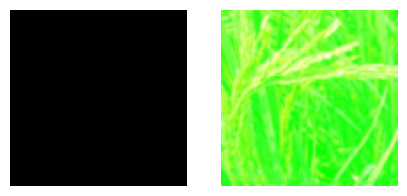

In [24]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
import numpy as np

def read_and_transform_img(url):
    try:
        img = imread(url)
    except FileNotFoundError:
        print("File not found at the specified location.")
        return None
    
    img = resize(img, (100,100))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

url = r'D:/sem7/project/Rice_Seed_Dataset/Unhealthy_Images/unhealthy (428).jpg'
images = read_and_transform_img(url)

if images is not None:
    # Make predictions using the model
    preds = model.predict(images)
    prediction = np.argmax(preds)
    confidence = np.max(preds)
    print(f"Predicted class: {prediction}, Confidence: {preds}")

from lime import lime_image


explainer = lime_image.LimeImageExplainer()

     

explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')

ax2.axis('off')